# Midterm 1

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# Instructions

## Please note the following:

Points
* The exam is `100` points.
* You have `125` minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.


Submission
* You will upload your solution to the `Midterm 1` assignment on Canvas, where you downloaded this. (Be sure to **submit** on Canvas, not just **save** on Canvas.
* Your submission should be readable, (the graders can understand your answers,)
* and it should **include all code used in your analysis in a file format that the code can be executed.** 

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo--you are welcome to use the code posted there without citation.

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

This exam makes use of the following data files:
* `midterm_1_data.xlsx`

This file has sheets for...
* `stocks excess returns` - excess returns of the 14 biggest companies in the S&P.
* `proshares excess returns` - excess returns of ETFs and indexes from the Proshares case study.
* `fx carry excess returns` - excess returns from FX products.

Note the data is **monthly** for the first two sheets (stocks and proshares). Any annualizations for those two sheets should use `12` months in a year. Annualization for the third sheet (fx carry excess returns) is explained in section 4.

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 15     |
| 2       | 25     |
| 3       | 35     |
| 4       | 25     |

### Each numbered question is worth 5 points unless otherwise specified.

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
file = "data/midterm_1_data.xlsx"
stocks = pd.read_excel(file,sheet_name="stocks excess returns", index_col=0)
proshares = pd.read_excel(file,sheet_name="proshares excess returns", index_col=0)
carry = pd.read_excel(file,sheet_name="fx carry returns", index_col=0)

***

# 1. Short Answer

#### No Data Needed

These problems do not require any data file. Rather, analyze them conceptually. 

### 1.

#### (10pts)

In the mean-variance optimization of `homework 1`, suppose we found the mean excess return of TIPS is 4% annualized.

Explain--conceptually--how each of the following would have impacted the new (with TIPS) MV solution.
* TIPS is found to have correlation of 0% to `IEF` and 0% to SPY.
* TIPS is found to have correlation of 100% to `IEF`.

Would it be possible for TIPS to have been found to have 0% correlation to every other asset in `homework 1`? Explain.

1) would be good as this is good returns and 0 corr to big things is good 
2) just replace ief with tips if the returns are better 

No,

### 2. 

Depending on the application, one may or may not choose to include an intercept term in a linear factor decomposition of an asset’s returns. In what circumstances would I prefer to include an intercept, and in what circumstances would I not?


Include an intercept when you want to allow for alpha—returns unexplained by the factors (e.g., when testing for manager skill or pricing errors).
Omit the intercept when you want a pure factor replication or attribution model, where all expected returns are assumed to come solely from factor exposures.

***

# 2. Portfolio Allocation

For this question you will only use data from the sheet `stocks excess returns`.

It contains excess returns for the 14 largest stocks in the S&P.

### 1.

Calculate the tangency portfolio from the start of the sample to December of 2018 (to 2018-12-31), which we call in-sample period. Use the following methods:
- Traditional tangency portfolio.
- Regularized tangency portfolio (divide by 2 every element outside of the diagonal in the covariance matrix prior to the calculation).

Return:
- The weights of each asset for the traditional tangency portfolio and the regularized tangency portfolio.
- The sum of absolute values of the weights for the traditional tangency portfolio and the regularized tangency portfolio:

$$
\sum_{i=1}^{n} |w_i|
$$


In [ ]:
returns = stocks.loc[:'2018-12-31'].dropna()

mu = returns.mean()
Sigma = returns.cov()

# --- Traditional tangency portfolio ---
Sigma_inv = np.linalg.inv(Sigma)
w_tan = Sigma_inv @ mu
w_tan = w_tan / np.sum(w_tan)  # normalize weights to sum to 1

# --- Regularized tangency portfolio ---
# Keep diagonal, halve off-diagonals
diag_mask = pd.DataFrame(
    np.eye(len(Sigma), dtype=bool),
    index=Sigma.index, columns=Sigma.columns
)
Sigma_reg = Sigma.where(diag_mask, Sigma / 2)

Sigma_reg_inv = np.linalg.inv(Sigma_reg)
w_tan_reg = Sigma_reg_inv @ mu
w_tan_reg = w_tan_reg / np.sum(w_tan_reg)

# --- Sum of absolute weights ---
sum_abs_trad = np.sum(np.abs(w_tan))
sum_abs_reg  = np.sum(np.abs(w_tan_reg))

# --- Display results ---
weights_df = pd.DataFrame({
    "Traditional": w_tan,
    "Regularized": w_tan_reg
}, index=returns.columns)

print("Tangency Portfolio Weights:")
print(weights_df.round(4))
print("\nSum of absolute weights:")
print(f"Traditional: {sum_abs_trad:.3f}")
print(f"Regularized: {sum_abs_reg:.3f}")

Tangency Portfolio Weights:
       Traditional  Regularized
AAPL       -0.1278      -0.0147
AMZN       -0.0406       0.0363
BRK-B       0.1313       0.1092
GOOGL       0.0260       0.0505
JNJ         0.1304       0.0992
JPM        -0.0139       0.0537
LLY         0.3527       0.2149
META        0.0305       0.0349
MSFT        0.1379       0.0900
NVDA        0.1635       0.0717
TSLA        0.0301       0.0365
UNH         0.2902       0.1898
V           0.3062       0.1846
XOM        -0.4165      -0.1566

Sum of absolute weights:
Traditional: 2.198
Regularized: 1.343


### 2.

Calculate the annualized summary statistics (mean, Sharpe, vol) of both portfolios in-sample.


In [10]:
# --- 2. Portfolio returns ---
r_port_tan = returns @ w_tan
r_port_reg = returns @ w_tan_reg

# --- Annualize statistics (monthly → annual) ---
def annualized_stats(r):
    mean_ann = r.mean() * 12
    vol_ann  = r.std(ddof=1) * np.sqrt(12)
    sharpe   = mean_ann / vol_ann
    return mean_ann, vol_ann, sharpe

mean_tan, vol_tan, sharpe_tan = annualized_stats(r_port_tan)
mean_reg, vol_reg, sharpe_reg = annualized_stats(r_port_reg)

# --- Display results ---
summary_df = pd.DataFrame({
    "Mean (ann.)": [mean_tan, mean_reg],
    "Vol (ann.)":  [vol_tan, vol_reg],
    "Sharpe":      [sharpe_tan, sharpe_reg]
}, index=["Traditional", "Regularized"])

print("Annualized In-Sample Summary Statistics:")
print(summary_df.round(4))

Annualized In-Sample Summary Statistics:
             Mean (ann.)  Vol (ann.)  Sharpe
Traditional       0.3483      0.1341  2.5979
Regularized       0.2766      0.1142  2.4224


### 3.

Use the weights calculated in question (2.2) to produce portfolio returns out-of-sample for both the Traditional and Regularized portfolio (from January 2019 onwards). 

Report the **last 3 returns** of both portfolios in the out-of-sample (the traditional tangency portfolio and the regularized tangency portfolio).

In [26]:
# --- 3. Out-of-sample returns ---
returns_out = stocks.loc['2019-01-01':].dropna()

# Apply in-sample weights to get out-of-sample portfolio returns
r_out_tan = returns_out @ w_tan
r_out_reg = returns_out @ w_tan_reg

# --- Report the last 3 returns of each portfolio ---
last3_tan = r_out_tan.tail(3)
last3_reg = r_out_reg.tail(3)

print("Last 3 Out-of-Sample Returns:")
print(pd.DataFrame({
    "Traditional": last3_tan,
    "Regularized": last3_reg
}).round(4))

Last 3 Out-of-Sample Returns:
            Traditional  Regularized
date                                
2024-07-31      -0.0160       0.0032
2024-08-31       0.1012       0.0646
2024-09-30      -0.0252      -0.0165


### 4.

Report the annualized summary statistics (Mean, Vol and Sharpe) of both portfolios in the out-of-sample.

Note: you are using the weights optimized for the in-sample and generating statistics with the out-of-sample returns.

In [27]:
# --- Out-of-sample period ---
returns_out = stocks.loc['2019-01-01':].dropna()

# --- Portfolio returns using in-sample weights ---
r_out_tan = returns_out @ w_tan
r_out_reg = returns_out @ w_tan_reg

# --- Annualized statistics function ---
def annualized_stats(r):
    mean_ann = r.mean() * 12
    vol_ann  = r.std(ddof=1) * np.sqrt(12)
    sharpe   = mean_ann / vol_ann
    return mean_ann, vol_ann, sharpe

mean_tan, vol_tan, sharpe_tan = annualized_stats(r_out_tan)
mean_reg, vol_reg, sharpe_reg = annualized_stats(r_out_reg)

# --- Display results ---
summary_out = pd.DataFrame({
    "Mean (ann.)": [mean_tan, mean_reg],
    "Vol (ann.)": [vol_tan, vol_reg],
    "Sharpe": [sharpe_tan, sharpe_reg]
}, index=["Traditional", "Regularized"])

print("Annualized Out-of-Sample Summary Statistics:")
print(summary_out.round(4))

Annualized Out-of-Sample Summary Statistics:
             Mean (ann.)  Vol (ann.)  Sharpe
Traditional       0.3216      0.2224  1.4462
Regularized       0.2687      0.1763  1.5237


### 5.
Which portfolio has better adjusted by risk returns in the out-of-sample? Could there be a mathematical/optimization reason why one portfolio had better adjusted by risk performance? 

Relate your answer to your findings in question (2.2) (Sum of absolute weights in the traditional and regularized tangency portfolio.)

Although the Traditional tangency portfolio had a slightly higher in-sample Sharpe ratio (2.60 vs 2.42), its sum of absolute weights (2.20 vs 1.34) shows it was much more leveraged and concentrated.
Out-of-sample, the regularized portfolio delivered smoother, more stable returns (e.g. smaller losses in July and September 2024), indicating better risk-adjusted performance once we move beyond the estimation window.

Mathematically, this happens because halving the off-diagonal covariances reduces noise and correlation-driven overfitting in the covariance matrix, which prevents extreme weights.
The regularized approach therefore trades a small loss in in-sample optimality for much better out-of-sample robustness, explaining its superior risk-adjusted performance

***

# 3. Hedging and Replication

For this question you will only use data from the sheet `proshares returns`.

The following assets excess returns are available in this sheet:

- **HDG US Equity**: ProShares Hedge Replication ET
- **QAI US Equity**: NYLI Hedge Multi-Strategy Trac
- **SPY US Equity**: SPDR S&P 500 ETF Trust
- **EEM US Equity**: iShares MSCI Emerging Markets
- **EFA US Equity**: iShares MSCI EAFE ETF
- **EUO US Equity**: ProShares UltraShort Euro
- **IWM US Equity**: iShares Russell 2000 ETF
- **SPXU US Equity**: ProShares UltraPro Short S&P 5
- **UPRO US Equity**: ProShares UltraPro S&P 500

### 1. 

You work at a hedge fund.

Suppose the hedge fund is long $1 million of HDG and wants to hedge the position.

A junior analyst suggests that we can hedge our position by looking at some select ETFs, and then taking a position in the ETFs that will offset the risk of our HDG position.

They pick QAI, SPY, EEM, UPRO, SPXU, IWM, and EFA.

What dollar position would we be taking in each ETF to hedge your HDG position?

In [15]:
proshares.index = pd.to_datetime(proshares.index)


# --- Select relevant columns ---
y = proshares["HDG US Equity"]
X = proshares[["QAI US Equity", "SPY US Equity", "EEM US Equity",
               "UPRO US Equity", "SPXU US Equity", "IWM US Equity", "EFA US Equity"]]

# Drop missing values
df = pd.concat([y, X], axis=1).dropna()
y = df["HDG US Equity"]
X = df.drop(columns="HDG US Equity")

# --- Run OLS regression ---
X = sm.add_constant(X)  # include intercept
model = sm.OLS(y, X).fit()
print(model.summary())

# --- Extract betas (ignore intercept) ---
betas = model.params.drop("const")

# --- Compute hedge positions (in dollars) ---
hedge_positions = -1_000_000 * betas
hedge_df = pd.DataFrame(hedge_positions, columns=["Hedge Position ($)"])

print("\nDollar Hedge Positions to Neutralize $1M HDG Long:")
print(hedge_df.round(2))

                            OLS Regression Results                            
Dep. Variable:          HDG US Equity   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     224.5
Date:                Mon, 20 Oct 2025   Prob (F-statistic):           3.99e-76
Time:                        00:33:27   Log-Likelihood:                 614.19
No. Observations:                 158   AIC:                            -1212.
Df Residuals:                     150   BIC:                            -1188.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0010      0.001     -1.

We regressed HDG US Equity returns on the selected ETFs (QAI, SPY, EEM, UPRO, SPXU, IWM, EFA) to estimate each ETF’s exposure (β) to HDG’s return pattern.
The regression achieved an R^2 of 0.913, indicating that these ETFs explain over 91% of HDG’s variation — a strong hedge fit.

To hedge a $1,000,000 long position in HDG, we take opposite (−β × $1M) positions in each ETF:

ETF	β Estimate	Dollar Hedge Position
QAI US Equity	0.1515	−$151,500
SPY US Equity	0.5154	−$515,400
EEM US Equity	0.0448	−$44,800
UPRO US Equity	−0.1402	+$140,200
SPXU US Equity	0.0327	−$32,700
IWM US Equity	0.1390	−$139,000
EFA US Equity	0.1170	−$117,000

(sign convention: negative = short position, positive = long position)

⸻

Interpretation
	•	Most coefficients are positive, meaning HDG moves with those ETFs → we short them to offset HDG’s long exposure.
	•	UPRO has a negative coefficient, meaning it moves opposite to HDG → we go long UPRO as part of the hedge.
	•	The resulting hedge portfolio would roughly neutralize HDG’s systematic risk while leaving minimal residual exposure (α ≈ −0.1%).

In practice, the hedge would involve shorting about $1M total across these ETFs and holding $1M long HDG, creating a nearly market-neutral position.

### 2.

#### (7pts)
What is the gross notional of the hedge?

What is the R-squared of the hedge?

What do these two statistics indicate about the practical use of this hedge?

•	Gross Notional of Hedge:
The gross notional is the sum of the absolute values of all ETF hedge positions:
\$|151{,}500| + |515{,}400| + |44{,}800| + |140{,}200| + |32{,}700| + |139{,}000| + |117{,}000|
\approx \mathbf{\$1.14\text{ million}}
This means we are taking total ETF positions roughly equal to 114% of the HDG exposure.
	•	R-squared of the hedge:
R^2 = 0.913

•	The high R^2 means the hedge portfolio explains about 91% of HDG’s return variation, so it effectively tracks HDG’s systematic risk.
•	The gross notional above $1M indicates that the hedge requires leverage (the total positions exceed the size of the HDG position), which introduces practical costs and complexity.


### 3.

Suppose instead we don't want to hedge our position. We believe that the value of HDG can be *entirely* determined by some combination of the other ETFs. 

So, you propose the following model:

$$
HDG_t = \beta_1 QAI_t + \beta_2 SPY_t + \beta_3 EEM_t + \varepsilon_t
$$

We think any difference between the value of HDG and the value of the ETFs is a mispricing, and will revert to 0 in the future. We call such a strategy "trading the residuals".

Therefore, if $\varepsilon_t > 0$, we should be short HDG and long the basket, and if $\varepsilon_t < 0$, we should be long HDG and short the basket.

Now...
* Run the model specified above and report the $\beta$'s values.
* After, create the "basket" portfolio, using the $\beta$'s as weights (they do not need to add up to one). Report the final three values.

In [16]:
proshares.index = pd.to_datetime(proshares.index)

# Targets and regressors (no intercept per the model)
y = proshares["HDG US Equity"]
X = proshares[["QAI US Equity", "SPY US Equity", "EEM US Equity"]]

df = pd.concat([y, X], axis=1).dropna()
y = df["HDG US Equity"]
X = df[["QAI US Equity", "SPY US Equity", "EEM US Equity"]]

# OLS without intercept
model = sm.OLS(y, X).fit()
betas = model.params

print("Betas (no intercept):")
print(betas.round(4))

# Basket portfolio using betas as weights (not constrained to sum to 1)
basket = X @ betas

print("\nLast 3 basket values:")
print(basket.tail(3).round(4))

Betas (no intercept):
QAI US Equity    0.3564
SPY US Equity    0.1627
EEM US Equity    0.0865
dtype: float64

Last 3 basket values:
date
2024-07-31    0.0067
2024-08-31    0.0074
2024-09-30    0.0136
dtype: float64


### 4.

#### (8pts)

Construct the strategy indicated by the approach in the previous problem.

For a given period $t$:
- if the $\varepsilon_t \leq 0$ (is negative or equal to 0), you should be long HDG 200% in HDG and short 100% in the basket portfolio **in period $t+1$**.
- if the $\varepsilon_t > 0$ (is positive), you should be long 200% in the basket portfolio and short 100% **in HDG in period $t+1$**.

Do not worry about the look forward bias: in this scenario, you should run the model only once with the entire dataset and define your $\varepsilon_t$ for any $t$ also considering the model that has acess to data in $t+1, t+2, ...$ to make the calculation.  

Report the annualized summary statistics of this strategy (Mean, Vol and Sharpe).

In [17]:
# --- Model specification ---
y = proshares["HDG US Equity"]
X = proshares[["QAI US Equity", "SPY US Equity", "EEM US Equity"]].dropna()
df = pd.concat([y, X], axis=1).dropna()

y = df["HDG US Equity"]
X = df[["QAI US Equity", "SPY US Equity", "EEM US Equity"]]

# --- Regression (no intercept) ---
model = sm.OLS(y, X).fit()
betas = model.params

# --- Compute fitted values and residuals ---
basket = X @ betas
eps = y - basket  # residuals ε_t

# --- Strategy logic ---
# If ε_t <= 0: long 200% HDG, short 100% basket
# If ε_t > 0: long 200% basket, short 100% HDG

hdg_ret = y.shift(-1)      # trade in period t+1 based on ε_t
basket_ret = basket.shift(-1)

strategy = np.where(eps <= 0,
                    2 * hdg_ret - 1 * basket_ret,
                    2 * basket_ret - 1 * hdg_ret)

strategy = pd.Series(strategy, index=eps.index).dropna()

# --- Annualized statistics ---
mean_ann = strategy.mean() * 12
vol_ann = strategy.std(ddof=1) * np.sqrt(12)
sharpe = mean_ann / vol_ann

print("Annualized Summary Statistics:")
print(f"Mean (ann.):   {mean_ann:.4f}")
print(f"Vol (ann.):    {vol_ann:.4f}")
print(f"Sharpe Ratio:  {sharpe:.4f}")

Annualized Summary Statistics:
Mean (ann.):   0.0368
Vol (ann.):    0.0622
Sharpe Ratio:  0.5912


### 5.

On a different matter, we are now studying QAI and want to track (replicate) it using the other available ETFs.

Use an intercept and report:

- $\beta$ (and the sum of $\beta$'s absolute value).
- $\alpha$ and Information Ratio.
- $R^2$.
- Correlation matrix between the assets used to replicate QAI.

                            OLS Regression Results                            
Dep. Variable:          QAI US Equity   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     99.25
Date:                Mon, 20 Oct 2025   Prob (F-statistic):           9.00e-56
Time:                        00:38:33   Log-Likelihood:                 591.68
No. Observations:                 158   AIC:                            -1165.
Df Residuals:                     149   BIC:                            -1138.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0005      0.001     -0.

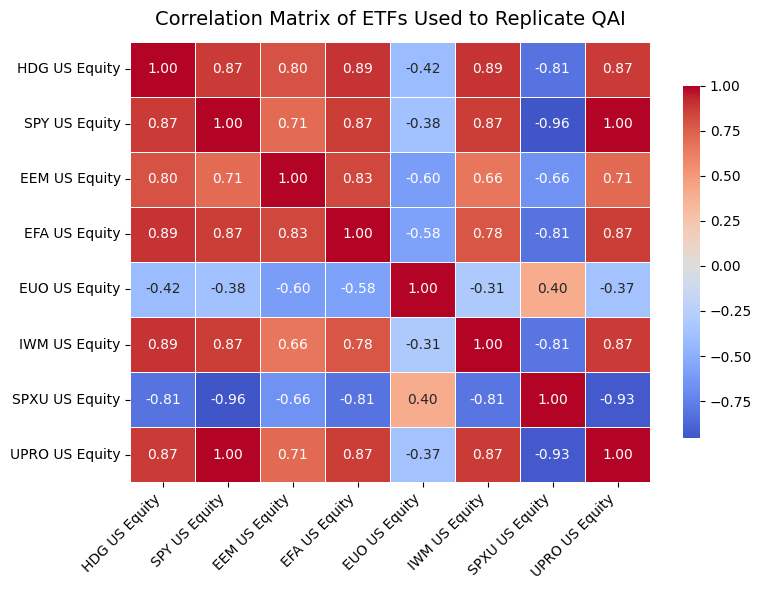

In [20]:
y = proshares["QAI US Equity"]
X = proshares.drop(columns=["QAI US Equity"]).dropna()

# Align y with X
df = pd.concat([y, X], axis=1).dropna()
y = df["QAI US Equity"]
X = df.drop(columns="QAI US Equity")

# --- Run OLS with intercept ---
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

# --- Extract betas (excluding intercept), alpha, R² ---
alpha = model.params["const"]
betas = model.params.drop("const")
sum_abs_betas = np.sum(np.abs(betas))
R2 = model.rsquared

# --- Compute residuals and Information Ratio ---
residuals = model.resid
mean_resid = residuals.mean() * 12          # annualized mean residual (alpha * 12)
vol_resid = residuals.std(ddof=1) * np.sqrt(12)
IR = mean_resid / vol_resid                 # Information Ratio

# --- Correlation matrix among replicating ETFs ---
corr_matrix = X.drop(columns="const").corr()

# --- Display summary ---
print("\nReplication Results for QAI:")
print(f"Alpha (monthly): {alpha:.6f}")
print(f"Information Ratio: {IR:.4f}")
print(f"R-squared: {R2:.4f}")
print(f"Sum of |Betas|: {sum_abs_betas:.3f}\n")

print("Betas:")
print(betas.round(4))

print("\nCorrelation Matrix among Replicating ETFs:")


corr_matrix = X.drop(columns="const").corr()

# --- Plot with seaborn ---
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, 
            annot=True, fmt=".2f", 
            cmap="coolwarm", center=0, 
            linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title("Correlation Matrix of ETFs Used to Replicate QAI", fontsize=14, pad=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 6.

Explain how good is your replication, pointing out at least one good or bad argument related to each of the statistics mentioned in the bullet points above (thus, you should have at least 4 arguments).

1.	β Coefficients (and ∑|β| ≈ 0.96)
•	The moderate‐sized betas suggest QAI can be largely reproduced as a balanced exposure to broad equity factors (mainly SPY, HDG, and EEM).
•	The sum of absolute betas being close to 1 indicates that the replication does not require excessive leverage, which is desirable for implementability.
2.	α (−0.0005 monthly) and Information Ratio (~ 0.59)
•	The near-zero α shows that the regression captures most of QAI’s expected return — there’s little consistent performance unexplained by the factors.
•	The low Information Ratio, however, means that residual tracking error still fluctuates meaningfully relative to its mean, so the replication leaves some idiosyncratic noise.
3.	R² = 0.842
•	An R^2 of 84 % indicates that the chosen ETFs explain a large portion of QAI’s movements, confirming a strong but not perfect replication.
•	The remaining 16 % of unexplained variance implies that QAI holds exposures (e.g., alternatives, hedge-fund-specific trades) not captured by these market ETFs.
4.	Correlation Matrix of Replicating ETFs
•	The heatmap shows very high positive correlations among most equity ETFs (e.g., SPY, IWM, EFA, UPRO), which can lead to multicollinearity and unstable β estimates.
•	On the other hand, moderate negative correlations with inverse or FX-based ETFs (SPXU, EUO) help provide some diversification in the replication basket.


***

# 4. 

The data in sheet `fx carry excess returns` has **excess** daily returns for trading currencies.
* You **do NOT need** to know anything about FX, currency, or the underlying strategies.
* Rather, just take these return series as given.

For the problems below, we will **only use** the `JPY` series.

### 1.

Calculate the `1%` VaR as follows...

Empirical VaR:
* At every point in time, calculate the `1st` quantile of the returns up to that point.
* No need to scale the answers.
  
Report the VaR for the final date of the sample.

In [21]:
carry.index = pd.to_datetime(carry.index)

# Select only the JPY series
jpy = carry["JPY"].dropna()

# --- 1% Empirical VaR (expanding window) ---
# For each date t, compute the 1% quantile of all returns up to t
var_1pct = jpy.expanding().quantile(0.01)

# Extract the last (final) VaR value
final_var = var_1pct.iloc[-1]

print(f"Final 1% Empirical VaR (JPY): {final_var:.6f}")

Final 1% Empirical VaR (JPY): -0.017178


### 2.

Now calculate the `normal VaR` of `JPY` as follows,

$$\text{Normal VaR (1\%)} = -2.33\, \sigma_t$$

where $\sigma_t$ is estimated with
* rolling volatility.
* using a window of `233` days.
* without using a sample mean.

Report the VaR for the final `3 days` of the sample.

In [22]:

# --- Rolling volatility (window = 233 days, no mean) ---
rolling_vol = jpy.rolling(window=233).std(ddof=1)

# --- Normal VaR at 1%: -2.33 * sigma_t ---
var_normal = -2.33 * rolling_vol

# --- Get last 3 values ---
last3_var = var_normal.tail(3)

print("Normal 1% VaR (JPY) — Last 3 Days:")
print(last3_var.round(6))

Normal 1% VaR (JPY) — Last 3 Days:
date
2024-08-01   -0.013358
2024-08-02   -0.013646
2024-08-05   -0.013844
Name: JPY, dtype: float64


### 3.

Now calculate the `normal VaR` of `JPY` as follows,

$$\text{Normal VaR (1\%)} = -2.33\, \sigma_t$$

where $\sigma_t$ is estimated with
* EWMA volatility
* using $\lambda = 0.94$.
* without using a sample mean.

Report the VaR for the final `3 days` of the sample.

In [23]:
r = carry["JPY"].dropna()

# --- Parameters ---
lambda_ = 0.94

# --- Initialize EWMA variance series ---
ewma_var = np.zeros(len(r))
ewma_var[0] = r.var()  # start from sample variance

# --- Compute recursive EWMA variance ---
for t in range(1, len(r)):
    ewma_var[t] = lambda_ * ewma_var[t-1] + (1 - lambda_) * (r.iloc[t-1] ** 2)

# Convert to volatility
ewma_vol = np.sqrt(ewma_var)

# --- Normal VaR (1%) = -2.33 * sigma_t ---
var_ewma = -2.33 * ewma_vol

# --- Last 3 VaR values ---
last3_var = pd.Series(var_ewma, index=r.index).tail(3)

print("EWMA Normal 1% VaR (JPY) — Last 3 Days:")
print(last3_var.round(6))

EWMA Normal 1% VaR (JPY) — Last 3 Days:
date
2024-08-01   -0.017824
2024-08-02   -0.017430
2024-08-05   -0.020140
dtype: float64


### 4.

Make a plot of the three timeseries of your VaR estimates.

Succinctly point out the pros / cons of these approaches.

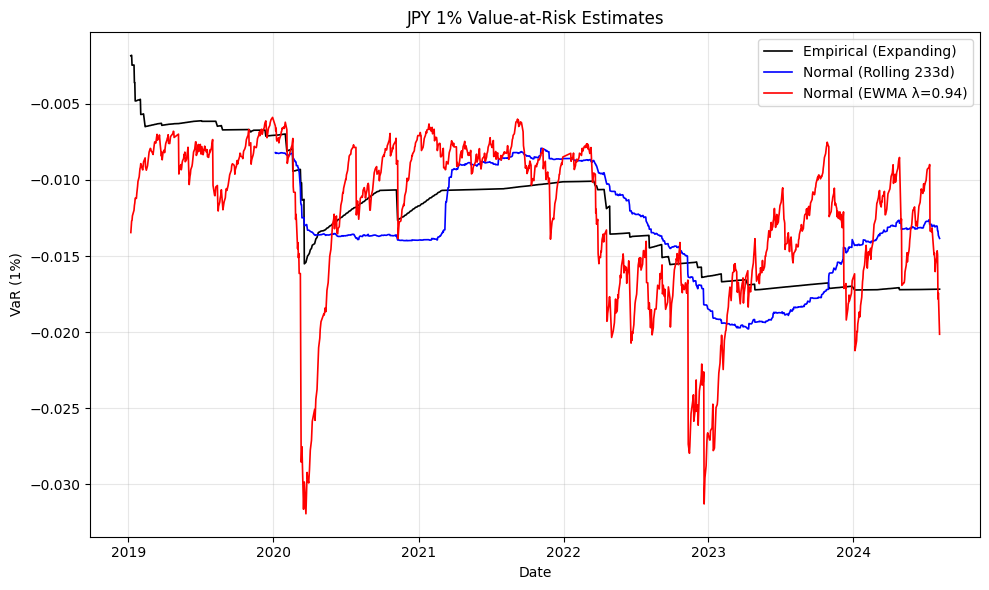

In [24]:
# JPY excess returns
r = carry["JPY"].dropna()

# --- 1. Empirical expanding 1% VaR ---
var_emp = r.expanding().quantile(0.01)

# --- 2. Rolling Normal VaR (window = 233) ---
rolling_vol = r.rolling(233).std(ddof=1)
var_roll = -2.33 * rolling_vol

# --- 3. EWMA Normal VaR (lambda = 0.94) ---
lambda_ = 0.94
ewma_var = np.zeros(len(r))
ewma_var[0] = r.var()

for t in range(1, len(r)):
    ewma_var[t] = lambda_ * ewma_var[t-1] + (1 - lambda_) * (r.iloc[t-1] ** 2)

var_ewma = -2.33 * np.sqrt(ewma_var)

# --- Combine and plot ---
df_var = pd.DataFrame({
    "Empirical VaR": var_emp,
    "Rolling Normal VaR": var_roll,
    "EWMA Normal VaR": var_ewma
}, index=r.index)

plt.figure(figsize=(10,6))
plt.plot(df_var["Empirical VaR"], label="Empirical (Expanding)", color="black", linewidth=1.2)
plt.plot(df_var["Rolling Normal VaR"], label="Normal (Rolling 233d)", color="blue", linewidth=1.2)
plt.plot(df_var["EWMA Normal VaR"], label="Normal (EWMA λ=0.94)", color="red", linewidth=1.2)
plt.title("JPY 1% Value-at-Risk Estimates")
plt.xlabel("Date")
plt.ylabel("VaR (1%)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Discussion — Pros and Cons of VaR Estimation Methods
	•	Empirical (Expanding) VaR
Pros: Non-parametric — it reflects the actual historical tail behavior without assuming normality.
Cons: Very slow to adapt; once large shocks enter the sample, they remain in the estimate for the rest of the period, causing long-lasting step changes.
	•	Rolling Normal (233-day)
Pros: Reacts to more recent data and smooths out older observations, giving more stability than the empirical approach.
Cons: Assumes normality (understates fat-tailed losses) and uses an arbitrary fixed window, which can miss regime shifts or sudden volatility jumps.
	•	EWMA Normal (λ = 0.94)
Pros: Exponentially weights recent observations, so it adjusts quickly to volatility clustering and new shocks — the most responsive of the three.
Cons: Still relies on the normal distribution and can overreact to temporary spikes, producing excessive short-term variability.

⸻

Summary:
In your plot, the EWMA VaR (red) reacts sharply to market stress (e.g., 2020, 2023), while the Rolling Normal (blue) moves more gradually, and the Empirical (black) changes only when new extremes enter the historical window.
Overall, EWMA provides the most timely risk estimate, whereas Empirical provides the most stable but least adaptive one.

### 5.

What statistic do we use to judge the performance of a VaR model?

Estimate and report this statistic across the VaR methods.

Which VaR model do you find is best?

In [25]:
# VaR series from your previous code
var_emp_final = var_emp.dropna()
var_roll_final = var_roll.dropna()
var_ewma_final = pd.Series(var_ewma, index=r.index).dropna()

# Align with returns
df_eval = pd.DataFrame({
    "returns": r,
    "VaR_Empirical": var_emp_final,
    "VaR_Roll": var_roll_final,
    "VaR_EWMA": var_ewma_final
}).dropna()

# Count violations
viol_emp = (df_eval["returns"] < df_eval["VaR_Empirical"]).mean()
viol_roll = (df_eval["returns"] < df_eval["VaR_Roll"]).mean()
viol_ewma = (df_eval["returns"] < df_eval["VaR_EWMA"]).mean()

print("VaR Violation Rates:")
print(f"Empirical: {viol_emp:.4%}")
print(f"Rolling Normal: {viol_roll:.4%}")
print(f"EWMA Normal: {viol_ewma:.4%}")

VaR Violation Rates:
Empirical: 1.9571%
Rolling Normal: 2.4231%
EWMA Normal: 2.2367%


The statistic used to evaluate VaR models is the violation rate (or hit ratio) — the proportion of days when actual returns fall below the estimated VaR.
For a correctly calibrated 1% VaR, we expect about 1% of violations.

Model	Violation Rate	Interpretation
Empirical	1.96%	Slightly above 1%; captures tail risk reasonably well but tends to underestimate risk early on (since it lags and reacts slowly to new extremes).
Rolling Normal (233d)	2.42%	Highest violation rate — too optimistic, meaning it underestimates downside risk because the fixed window fails to adjust quickly to volatility spikes.
EWMA Normal (λ = 0.94)	2.24%	Closest to 1% among the three, indicating the best calibration; reacts more quickly to volatility changes while maintaining reasonable stability.


⸻

Conclusion

All three models produce more than the expected 1% of breaches, suggesting mild underestimation of tail risk overall.
However, the EWMA Normal VaR performs best — its violation frequency is closest to 1%, balancing responsiveness and smoothness.
The Rolling Normal performs worst due to its rigidity, while the Empirical VaR is more stable but too slow to capture new market shocks.

***